In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import functions

import glob
import pandas as pd
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### df vs ff, daily vs once, langtang vs mustang -> 4 rows total 


In [12]:
# functions 

start_date = "1990-07-31"
end_date = "2021-06-30"


def filter_by_date(df, start_date = start_date, end_date = end_date, date_column='D'):
    """
    Filters a DataFrame to include only rows where the date_column is within the given range.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        start_date (str or pd.Timestamp): The start date (inclusive).
        end_date (str or pd.Timestamp): The end date (inclusive).
        date_column (str): The column containing date values (default is 'D').

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    df[date_column] = pd.to_datetime(df[date_column])  # Convert to datetime
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]


# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'  # December, January, February (Winter)
    elif month in [3, 4, 5]:
        return 'MAM'  # March, April, May (Spring)
    elif month in [6, 7, 8]:
        return 'JJA'  # June, July, August (Summer)
    else:
        return 'SON'  # September, October, November (Autumn)

# Define a function to categorize seasons
def get_monsoon(month):
    if month in [1, 2, 3, 4]:
        return 'before monsoon'  
    elif month in [5, 6, 7, 8, 9]:
        return month  # should remain the same 
    elif month in [10, 11, 12]:
        return 'after monsoon'  # June, July, August (Summer)

def prepare_dfcount_for_plot(dfcount):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 


def prepare_dfcount_for_barplot(dfcount, landcover_idx):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    melted['monsoon'] = melted['D_month'].apply(get_monsoon)

    melted['landcover'] = f'landcover {landcover_idx}'
    return melted 



def merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column):
    """
    Merges a list of dataframes on specified columns and adds a column from a 'dfspot' dataframe.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to merge sequentially.
        dfspot (pd.DataFrame): A dataframe containing a column to add after the merges.
        merge_on (list of str): Columns to use as the merge keys.
        dfspot_column (str): The name of the column in `dfspot` to add after merging.
        
    Returns:
        pd.DataFrame: The merged dataframe with the additional column from `dfspot`.
    """
    
    # Start with the first dataframe in `dfs` and automatically get the count column
    count_column = [col for col in dfs[0].columns if col.startswith('dfs_count')][0]
    merged_df = dfs[0][merge_on + [count_column]]
    
    # Iterate over remaining dataframes and merge each sequentially
    for df in dfs[1:]:
        count_column = [col for col in df.columns if col.startswith('dfs_count')][0]
        merged_df = pd.merge(merged_df, df[merge_on + [count_column]], on=merge_on)
    
    # Add the `dfspot_column` from `dfspot` dataframe to the merged dataframe
    merged_df['dfspot_count'] = dfspot[dfspot_column]
    
    return merged_df


def calculate_floods(df):
    # df percent 
    df[f'dfs_count_60_percent'] = (df[f'dfs_count_60percent'] *100) / df.dfspot_count
    df[f'dfs_count_50_percent'] = (df[f'dfs_count_50percent'] *100) / df.dfspot_count
    df[f'dfs_count_40_percent'] = (df[f'dfs_count_40percent'] *100) / df.dfspot_count
    df[f'dfs_count_30_percent'] = (df[f'dfs_count_30percent'] *100) / df.dfspot_count
    df[f'dfs_count_20_percent'] = (df[f'dfs_count_20percent'] *100) / df.dfspot_count
    # ff count 
    df[f'ffs_count_60'] = df.dfspot_count - df[f'dfs_count_60percent']
    df[f'ffs_count_50'] = df.dfspot_count - df[f'dfs_count_50percent']
    df[f'ffs_count_40'] = df.dfspot_count - df[f'dfs_count_40percent']
    df[f'ffs_count_30'] = df.dfspot_count - df[f'dfs_count_30percent']
    df[f'ffs_count_20'] = df.dfspot_count - df[f'dfs_count_20percent']
    # ff percent
    df[f'ffs_count_60_percent'] = (df[f'ffs_count_60'] *100) / df.dfspot_count
    df[f'ffs_count_50_percent'] = (df[f'ffs_count_50'] *100) / df.dfspot_count
    df[f'ffs_count_40_percent'] = (df[f'ffs_count_40'] *100) / df.dfspot_count
    df[f'ffs_count_30_percent'] = (df[f'ffs_count_30'] *100) / df.dfspot_count
    df[f'ffs_count_20_percent'] = (df[f'ffs_count_20'] *100) / df.dfspot_count
    return df



# langtang - potential


In [54]:
location = 'mustang'

path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/'
dfspot1_df = pd.read_csv(path + f'{location}_monthly_dfspot_count_landcover1.csv', index_col = 0).fillna(0)
dfspot2_df = pd.read_csv(path + f'{location}_monthly_dfspot_count_landcover2.csv', index_col = 0).fillna(0)
dfspot3_df = pd.read_csv(path + f'{location}_monthly_dfspot_count_landcover3.csv', index_col = 0).fillna(0)
dfspot4_df = pd.read_csv(path + f'{location}_monthly_dfspot_count_landcover4.csv', index_col = 0).fillna(0)
dfspot5_df = pd.read_csv(path + f'{location}_monthly_dfspot_count_landcover5.csv', index_col = 0).fillna(0)

dfspot1_df = filter_by_date(dfspot1_df)
dfspot2_df = filter_by_date(dfspot2_df)
dfspot3_df = filter_by_date(dfspot3_df)
dfspot4_df = filter_by_date(dfspot4_df)
dfspot5_df = filter_by_date(dfspot5_df)

dfspot1 = prepare_dfcount_for_barplot(dfspot1_df, 1).fillna(0)
dfspot2 = prepare_dfcount_for_barplot(dfspot2_df, 2).fillna(0)
dfspot3 = prepare_dfcount_for_barplot(dfspot3_df, 3).fillna(0)
dfspot4 = prepare_dfcount_for_barplot(dfspot4_df, 4).fillna(0)
dfspot5 = prepare_dfcount_for_barplot(dfspot5_df, 5).fillna(0)

In [61]:
# dfspot3_df

# once and daily

In [43]:

landcover_idx = 5
method = 'once'
location = 'langtang'



# Base directory where all output_Xpercent folders are located
base_directory = f"/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_{method}/"

# Use glob to find all relevant files in output_XXpercent folders
file_pattern = f"{base_directory}/output_*/langtang_monthly_dfs_count_*_landcover{landcover_idx}.csv"
files = glob.glob(file_pattern)

dfs = []

# Loop through the files and process them
for file in files:
    # Extract the percentile from the folder name
    percentile = re.search(r'output_(\d+percent)', file).group(1)
    
    # Extract the landcover number from the file name
    landcover_number = re.search(r'landcover(\d+)', file).group(1)
    print(landcover_number)
    print(file)
    # Read the file into a DataFrame
    df = pd.read_csv(file, index_col=0).fillna(0)
    df = filter_by_date(df)

    # Apply your processing function
    processed_df = prepare_dfcount_for_plot(df)
    
    # Rename the 'dfs_count' column to include percentile and landcover number
    processed_df = processed_df.rename(columns={'dfs_count': f'dfs_count_{percentile}'})
    # Append to the list
    dfs.append(processed_df)

merge_on = ['year', 'month', 'elevation', 'elevation_bin', 'id']
dfspot_column = 'dfs_count'

if landcover_idx == 1:
    dfspot = dfspot1
if landcover_idx == 2:
    dfspot = dfspot2
if landcover_idx == 3:
    dfspot = dfspot3
if landcover_idx == 4:
    dfspot = dfspot4
if landcover_idx == 5:
    dfspot = dfspot5


dfmerged = merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column)
dffloods = calculate_floods(dfmerged)


outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/'
# dffloods.to_csv(outpath + f'{location}_df_vs_floods_{method}_landcover{landcover_idx}.csv')


5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_30percent/langtang_monthly_dfs_count_30percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_20percent/langtang_monthly_dfs_count_20percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_60percent/langtang_monthly_dfs_count_60percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_40percent/langtang_monthly_dfs_count_40percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_50percent/langtang_monthly_dfs_count_50percent_landcover5.csv


# plots with bubbles 

In [67]:
# read those files 
# outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/'

landcover1O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover1.csv', index_col=0)
landcover2O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover2.csv', index_col=0)
landcover3O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover3.csv', index_col=0)
landcover4O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover4.csv', index_col=0)
landcover5O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover5.csv', index_col=0)


landcover1D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover1.csv', index_col=0)
landcover2D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover2.csv', index_col=0)
landcover3D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover3.csv', index_col=0)
landcover4D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover4.csv', index_col=0)
landcover5D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover5.csv', index_col=0)


In [68]:
# # check the "empty" elevation bins without any DFs potentially 

# dfs = {"df1": landcover1, "df2": landcover2, "df3": landcover3, "df4": landcover4, "df5": landcover5}  # Example dictionary of dataframes

# empty_bins_per_df = {}

# for name, df in dfs.items():
#     # empty_bins = df.groupby("elevation_bin")["dfspot_count"].apply(lambda x: (x.isna() | (x == 0)).all())
#     empty_bins = df.groupby("elevation_bin")["dfspot_count"].apply(lambda x: (x.isna()).all())
#     empty_bins_per_df[name] = empty_bins[empty_bins].index.tolist()

# # Print results
# for name, empty_bins in empty_bins_per_df.items():
#     print(f"Elevation bins with only 0/NaN dfspot in {name}: {empty_bins}")


In [86]:
# def monthly_mean_per_elevation(df):
#     mean = df.groupby(['elevation_bin', 'month']).mean().reset_index() 
#     return mean
    
def monthly_mean(df):
    mean = df.groupby(['month']).mean().reset_index() 
    return mean


# landcover1monthly_comb = monthly_mean(landcover1)
# landcover2monthly_comb = monthly_mean(landcover2)
# landcover3monthly_comb = monthly_mean(landcover3)
# landcover4monthly_comb = monthly_mean(landcover4)
# landcover5monthly_comb = monthly_mean(landcover5)


landcover1monthlyO = monthly_mean(landcover1O)
landcover2monthlyO = monthly_mean(landcover2O)
landcover3monthlyO = monthly_mean(landcover3O)
landcover4monthlyO = monthly_mean(landcover4O)
landcover5monthlyO = monthly_mean(landcover5O)

landcover1monthlyO['landcover']='landcover 1'
landcover2monthlyO['landcover']='landcover 2'
landcover3monthlyO['landcover']='landcover 3'
landcover4monthlyO['landcover']='landcover 4'
landcover5monthlyO['landcover']='landcover 5'

landcover1monthlyD = monthly_mean(landcover1D)
landcover2monthlyD = monthly_mean(landcover2D)
landcover3monthlyD = monthly_mean(landcover3D)
landcover4monthlyD = monthly_mean(landcover4D)
landcover5monthlyD = monthly_mean(landcover5D)


landcover1monthlyD['landcover']='landcover 1'
landcover2monthlyD['landcover']='landcover 2'
landcover3monthlyD['landcover']='landcover 3'
landcover4monthlyD['landcover']='landcover 4'
landcover5monthlyD['landcover']='landcover 5'

landcover_all_month_daily = pd.concat([landcover1monthlyD, landcover2monthlyD, landcover3monthlyD, 
                                       landcover4monthlyD, landcover5monthlyD])

landcover_all_month_once = pd.concat([landcover1monthlyO, landcover2monthlyO, landcover3monthlyO, 
                                      landcover4monthlyO, landcover5monthlyO])

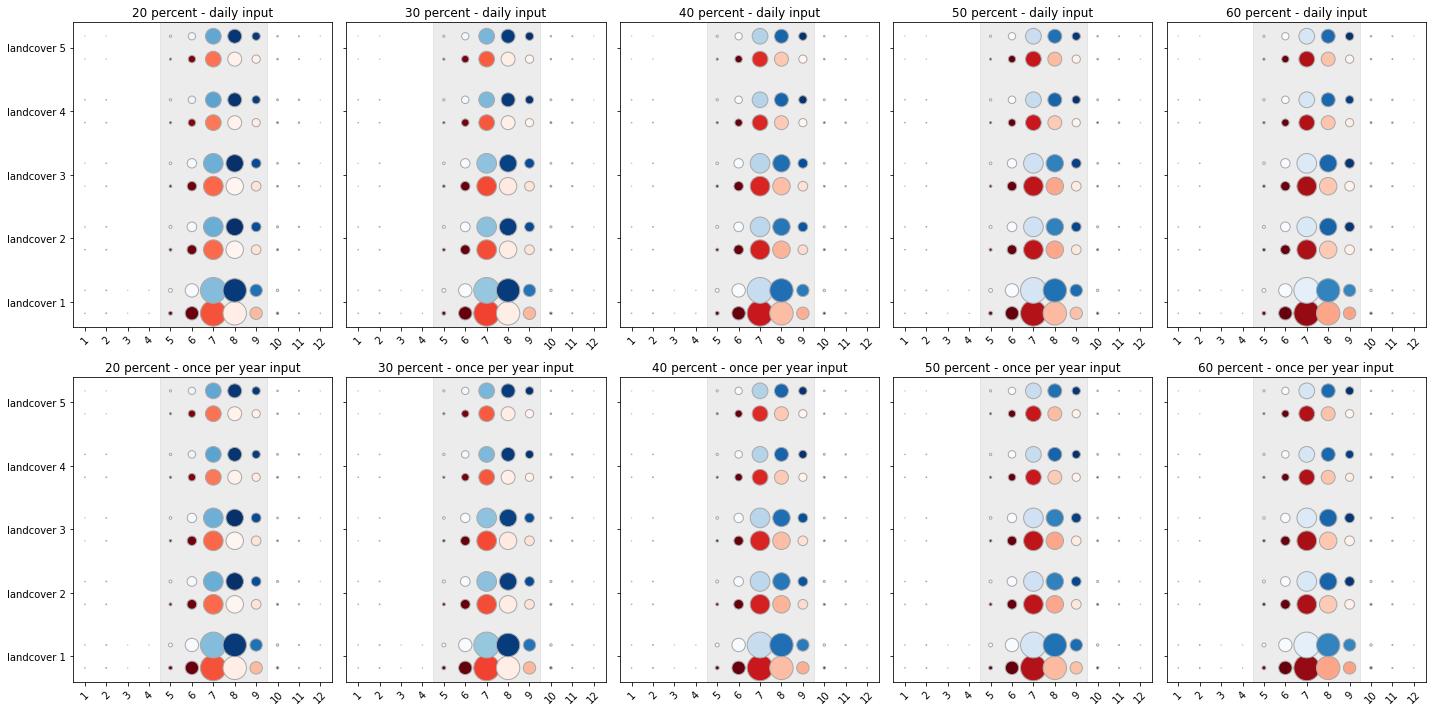

In [100]:
df = landcover_all_month_daily.copy()


# Convert categorical landcover to numeric for plotting
landcover_numeric, landcover_labels = pd.factorize(df.landcover)


fig = plt.figure(figsize=(20, 10), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')

# # Add a transparent grey box for monsoon season (May to September)
# mosaic['a'].axvspan(5-0.5, 9+0.5, color='grey', alpha=0.15)  
# mosaic['b'].axvspan(5-0.5, 9+0.5, color='grey', alpha=0.15)  
# mosaic['c'].axvspan(5-0.5, 9+0.5, color='grey', alpha=0.15)  
# mosaic['d'].axvspan(5-0.5, 9+0.5, color='grey', alpha=0.15)  
# mosaic['e'].axvspan(5-0.5, 9+0.5, color='grey', alpha=0.15)  

# Apply axvspan to all axes in the mosaic
for ax in mosaic.values():
    ax.axvspan(5 - 0.5, 9 + 0.5, color='grey', alpha=0.15)
# 

mosaic['a'].scatter(x = df.month, y = landcover_numeric-0.18, c = df.dfs_count_20_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['a'].scatter(x = df.month, y = landcover_numeric+0.18, c = df.ffs_count_20_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['b'].scatter(x = df.month, y = landcover_numeric-0.18, c = df.dfs_count_30_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['b'].scatter(x = df.month, y = landcover_numeric+0.18, c = df.ffs_count_30_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['c'].scatter(x = df.month, y = landcover_numeric-0.18, c = df.dfs_count_40_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['c'].scatter(x = df.month, y = landcover_numeric+0.18, c = df.ffs_count_40_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['d'].scatter(x = df.month, y = landcover_numeric-0.18, c = df.dfs_count_50_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['d'].scatter(x = df.month, y = landcover_numeric+0.18, c = df.ffs_count_50_percent*100, s = df.dfspot_count*100, cmap = 'Blues',edgecolor = 'darkgrey')

mosaic['e'].scatter(x = df.month, y = landcover_numeric-0.18, c = df.dfs_count_60_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['e'].scatter(x = df.month, y = landcover_numeric+0.18, c = df.ffs_count_60_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')


# Replace numeric ticks with original landcover labels
mosaic['a'].set_yticks(range(len(landcover_labels)))
mosaic['a'].set_yticklabels(landcover_labels)

mosaic['b'].set_yticklabels([])
mosaic['c'].set_yticklabels([])
mosaic['d'].set_yticklabels([])
mosaic['e'].set_yticklabels([])

mosaic['a'].set_title('20 percent - daily input')
mosaic['b'].set_title('30 percent - daily input')
mosaic['c'].set_title('40 percent - daily input')
mosaic['d'].set_title('50 percent - daily input')
mosaic['e'].set_title('60 percent - daily input')

# -----------------------------------------------

df1 = landcover_all_month_once.copy()


mosaic['A'].scatter(x = df1.month, y = landcover_numeric-0.18, c = df.dfs_count_20_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['A'].scatter(x = df1.month, y = landcover_numeric+0.18, c = df.ffs_count_20_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['B'].scatter(x = df1.month, y = landcover_numeric-0.18, c = df.dfs_count_30_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['B'].scatter(x = df1.month, y = landcover_numeric+0.18, c = df.ffs_count_30_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['C'].scatter(x = df1.month, y = landcover_numeric-0.18, c = df.dfs_count_40_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['C'].scatter(x = df1.month, y = landcover_numeric+0.18, c = df.ffs_count_40_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')

mosaic['D'].scatter(x = df1.month, y = landcover_numeric-0.18, c = df.dfs_count_50_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['D'].scatter(x = df1.month, y = landcover_numeric+0.18, c = df.ffs_count_50_percent*100, s = df.dfspot_count*100, cmap = 'Blues',edgecolor = 'darkgrey')

mosaic['E'].scatter(x = df1.month, y = landcover_numeric-0.18, c = df.dfs_count_60_percent*100, s = df.dfspot_count*100, cmap = 'Reds', edgecolor = 'darkgrey')
mosaic['E'].scatter(x = df1.month, y = landcover_numeric+0.18, c = df.ffs_count_60_percent*100, s = df.dfspot_count*100, cmap = 'Blues', edgecolor = 'darkgrey')



mosaic['A'].set_title('20 percent - once per year input')
mosaic['B'].set_title('30 percent - once per year input')
mosaic['C'].set_title('40 percent - once per year input')
mosaic['D'].set_title('50 percent - once per year input')
mosaic['E'].set_title('60 percent - once per year input')

# -------------------

for key in ['a', 'b', 'c', 'd', 'e','A', 'B', 'C', 'D', 'E']:
    mosaic[key].set_xticks(df.month.unique())  # Set tick positions
    mosaic[key].set_xticklabels(df.month.unique(), rotation=45)  # Set tick labels, rotate

for key in ['a', 'A']:
    mosaic[key].set_yticks(range(len(landcover_labels)))
    mosaic[key].set_yticklabels(landcover_labels)

for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_yticklabels([])




# ---- Create Color Legend ----
red_patch = mpatches.Patch(color='red', label='DFS')
blue_patch = mpatches.Patch(color='blue', label='FFS')


outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/'

# plt.savefig(outpath + 'langtang_count_df_per_month_bubbles.png', bbox_inches = 'tight', dpi = 300)
